<a href="https://colab.research.google.com/github/kitamura-felipe/treinando-1a-rede-neural/blob/master/Treinando_minha_1a_rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://github.com/kitamura-felipe/treinando-1a-rede-neural/raw/master/banner.jpg)

# Tutorial de treinamento de rede neural para classificação de tomografias de tórax com COVID-19 vs sem COVID-19

###Este tutorial foi baseado no trabalho do neurorradiologista Bradley J Erickson, MD PhD, publicado na Radiology: AI
https://pubs.rsna.org/doi/10.1148/ryai.2019190072

###Utilizamos o dataset de tomografias de COVID-19 da UCSD: 
https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/

## Agradecimento ao Dr. Gustavo Corradi, médico radiologista do AI Lab DASA

In [1]:
#Primeiro passo é instalar a biblioteca fastai, que utilizaremos para treinar nossa rede neural.
!pip3 install fastai
from fastai.vision import *

In [2]:
#Essa parte do código baixa images de tomografia de casos com COVID-19 e casos sem COVID-19

!rm -rf images
!rm -rf CT_COVID.zip?raw=true
!rm -rf CT_NonCOVID.zip?raw=true

!mkdir images

!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip?raw=true
!unzip -q CT_NonCOVID.zip?raw=true -d images/
!unzip -q CT_COVID.zip?raw=true -d images/

!rm -rf ./images/__MACOSX
!ls images


--2020-04-23 21:53:05--  https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip [following]
--2020-04-23 21:53:05--  https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip [following]
--2020-04-23 21:53:05--  https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

In [3]:
#Após baixar a extrair os arquivos ZIP, nós vamos listar as pastas criadas.
classes_dir = "./images"
flist = os.listdir(classes_dir)
print (flist)

['CT_NonCOVID', 'CT_COVID']


## Visualizando as images

In [6]:
#Nessa parte, vamos criar um objeto de dados com as imagens que baixamos. Iremos ajustar alguns parâmetros também.
np.random.seed(42)
data = ImageDataBunch.from_folder(classes_dir, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=128, num_workers=4).normalize(imagenet_stats)
data.classes
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['CT_COVID', 'CT_NonCOVID'], 2, 597, 149)

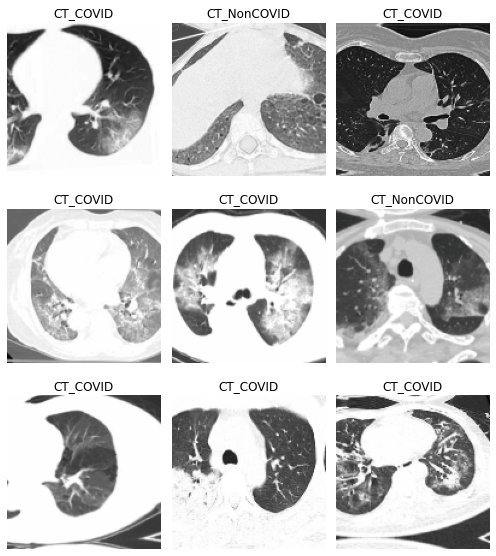

In [7]:
#Agora vamos ver as imagens que baixamos, após realizar algumas transformações 
data.show_batch(rows=3, figsize=(7,8))

def get_img(img_url): return open_image(img_url)

# Função para mostrar imagens transformadas
def plots_of_one_image(img_url, tfms, rows=1, cols=3, width=15, height=5, **kwargs):
    img = get_img(img_url)
    [img.apply_tfms(tfms, **kwargs).show(ax=ax)
         for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]
tfms = get_transforms(flip_vert=False,                # flip vertical
                      max_rotate=10.0,                # rotação entre -10° and 10°
                      max_zoom=1.2)                   # zoom entre 1 and 1.2


## Treinando a rede neural (modelo)

In [8]:
#Agora criaremos o objeto da rede neural, com a métrica de erro associada
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#learn = cnn_learner(data, models.resnet50, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


![alt text](https://i.pinimg.com/originals/11/df/a8/11dfa88cf0194f13497cb7fb13af3b12.gif)

In [9]:
#Esse é o momento que de fato o treinamento acontece.
learn.fit_one_cycle(5)
learn.save("MedNIST-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,1.286664,0.739352,0.281879,00:07
1,1.030060,0.815601,0.275168,00:07
2,0.959725,0.740082,0.281879,00:07
3,0.853956,0.640309,0.248322,00:07
4,0.803056,0.592473,0.261745,00:07


#Avaliação
* Durante o processo de treinamento, os dados são divididos em 3 partes: treino, validação e teste. As imagens de treino são usadas para ajustar os pesos. Quando todas as imagens de treino são "vistas" pelo modelo, temos 1 época. Quando termina cada época, avaliamos o quanto o modelo aprendeu nas imagens de validação. A performance no conjunto de treino é o train_loss e a performance no conjunto de validação é o valid_loss. O error_rate é a porcentagem  de casos errados no grupo de validação.

* Após termos atingido uma performance aceitável no conjunto de validação, testamos sua performance no conjunto de teste para ver como ele funcionará no mundo real.

* Algumas fontes trocam o conceito de validação e teste.

* Muitas vezes, saber apenas quantos porcento o modelo errou não é suficiente. Precisamos avaliar quantos falsos positivos e quantos falsos negativos ele gerou.

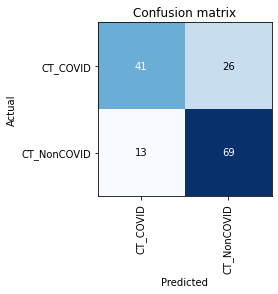

In [10]:
#Vamos avaliar o quanto modelo acerta/erra no conjunto de teste.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

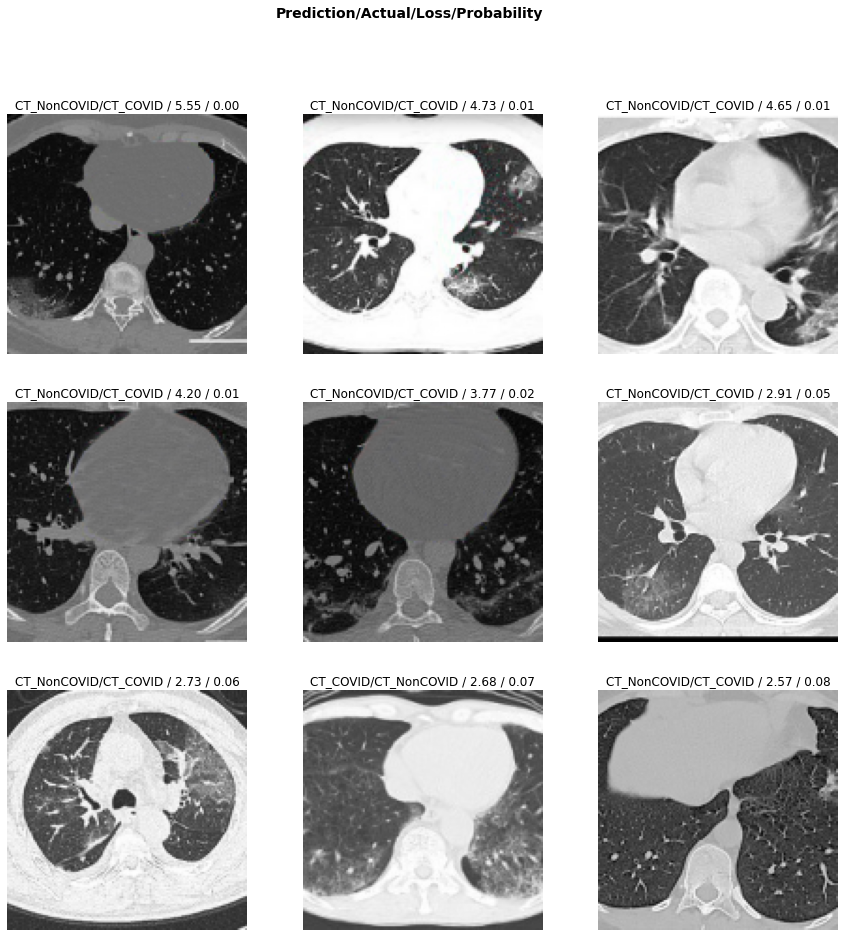

In [11]:
#Agora vamos olhar alguns casos em que o modelo errou
interp.plot_top_losses(9, figsize=(15,15))
doc(interp.plot_top_losses)